# Advanced Machine Learning
## Assignment 1
###  Agnija Ashtrita (MDS202103), Ashutosh Maurya (MDS202110)


In [1]:
import os, sys, random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch, torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

Task: Design a fully connected neural network that classifies pairs of handwritten digits


#### Defining Directories

In [2]:
root = os.getcwd()

data_folder = os.path.join(root, 'data')
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

output_folder = os.path.join(root, 'output')
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

#### Loading and Transforming Data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda img: img.view(28,28))])

data_train_full = torchvision.datasets.MNIST(root=data_folder, train=True, download=True, transform=transform)
data_test = torchvision.datasets.MNIST(root=data_folder, train=False, download=True, transform=transform) 

We get the training data by putting `train = True`. We apply the `ToTensor()` transformation to the dataset to convert the input into tensors, which are more convenient to work with.

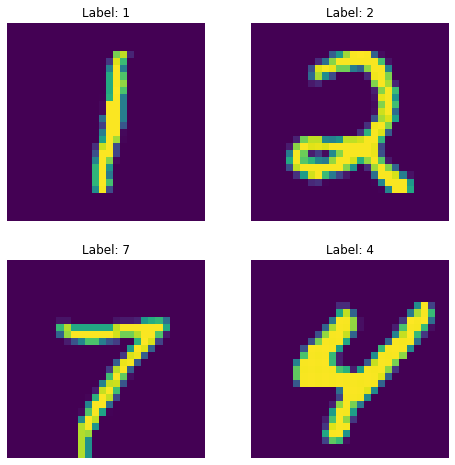

In [54]:
def plot_img(data):

    figure = plt.figure(figsize=(8, 8))
    cols, rows = 2,2
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label =  data[sample_idx]
        ax = figure.add_subplot(rows, cols, i)
        plt.axis("off")
        ax.title.set_text('Label: {}'.format(data[sample_idx][1]))
        plt.imshow(img.squeeze())
    plt.show()
    
plot_img(data_train_full)

#### Creating new training and test set of pair of digits

In [4]:
batch_size = 10

train_loader = DataLoader(data_train_full, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [5]:
batch1 = next(iter(train_loader))
batch1[0].size()

torch.Size([10, 28, 28])

In [6]:
 batch1[0].size()

torch.Size([10, 28, 28])

In [7]:
new_batch = [torch.empty(100,28,56), torch.empty(100)]
it1 = 0
it3 = 0
for img1 in batch1[0]:
    lab1 = int(batch1[1][it1])
    it2 = 0
    for img2 in batch1[0]:       
        lab2 = int(batch1[1][it2])     
        new_img = torch.cat((img1,img2),-1)
        new_batch[0][it3] = new_img
        new_batch[1][it3] = int(str(lab1)+str(lab2))   
        it2 += 1
        it3 += 1
    it1 += 1   
print(new_batch[0].size())

torch.Size([100, 28, 56])


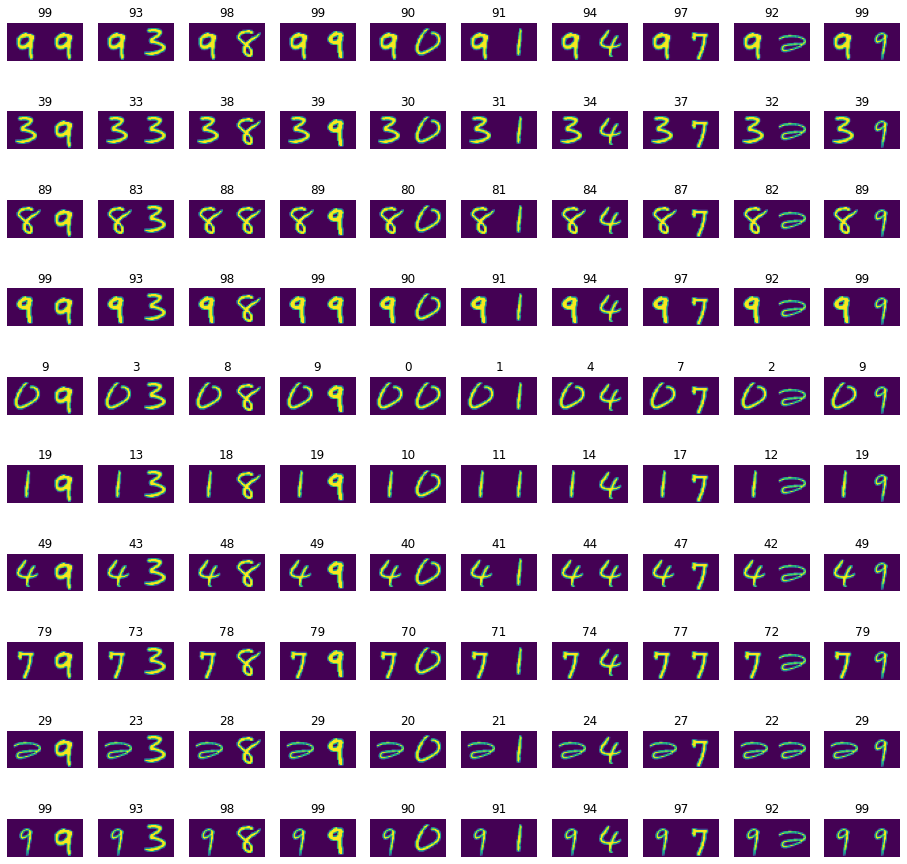

In [59]:
plt.figure(figsize=(16, 16))

# fetch a batch of train images; RANDOM
image_batch, label_batch = new_batch[0], new_batch[1]

for i in range(100):
    image = image_batch[i]
    label = int(label_batch[i])
    plt.subplot(10, 10, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

In [8]:
def double_digits(batch):

    new_batch = [torch.empty(100,1568), torch.empty(100)]
    it1 = 0
    it3 = 0
    for img1 in batch[0]:
        lab1 = int(batch[1][it1])
        it2 = 0
        for img2 in batch[0]:
            lab2 = int(batch[1][it2])             
            new_img = torch.cat((img1,img2),-1)
            new_img = torch.flatten(new_img) 
            new_batch[0][it3] = new_img
            new_batch[1][it3] = int(str(lab1)+str(lab2))   
            it2 += 1
            it3 +=1
        it1 += 1   

    return new_batch

#### Defining Fully Connected Neural Network

In [61]:
model1 = nn.Sequential(
    nn.Linear(1568, 500),
    nn.LeakyReLU(), 
    nn.Linear(500,500),
    nn.LeakyReLU(),
    nn.Linear(500,200), 
    nn.LeakyReLU(),
    nn.Linear(200, 100), 
    nn.LogSoftmax(dim=1)
)
model1

Sequential(
  (0): Linear(in_features=1568, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=500, out_features=200, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): LogSoftmax(dim=1)
)

We can see that we have created a Neural Network of the required architecture. 

Next, we train the network and test the dataset.

In [9]:
def train_and_test_dnn(train_dataloader, test_dataloader, model, num_epochs):

    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters()) # using ADAM optimizer

    # list to store losses per batch
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    preds_list = []

    for epoch in range(num_epochs):

        running_loss = 0.0
        running_corrects = 0
        N_tot = 0
        model.train()

        for _, data in enumerate(train_loader):
            data = double_digits(data)
            inputs, labels = data
            inputs = inputs.to(torch.float)
            labels = labels.to(torch.long) 
            opt.zero_grad() # setting gradients to zero
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1) # taking the max from the softmax output
            loss = criterion(outputs, labels) 
            loss.backward() # backpropagation
            opt.step()

            N_tot += outputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss.append(running_loss / N_tot)
        train_acc.append(running_corrects.item() / N_tot)

        print('| Epoch:[{}]\tTrain_Loss: {:.4f}\tAccuracy: {:.4f}'.format(epoch + 1, running_loss / N_tot, running_corrects.item() / N_tot))

    model.eval()
    for _, data in enumerate(test_loader):
        data = double_digits(data)
        inputs, labels = data
        inputs = inputs.to(torch.float) 
        labels = labels.to(torch.long) 
        opt.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        N_tot += outputs.size(0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        test_input_img = inputs
        test_labels = labels
        test_preds = preds
    
    test_loss, test_acc = running_loss / N_tot, running_corrects.item() / N_tot
    
    print('\n')
    print('| Model: model\tTest_Loss: {:.4f}\tAccuracy: {:.4f}'.format(test_loss,test_acc))
    print('\n')

    sys.stdout.flush()
    
    return train_loss, train_acc, test_loss, test_acc, test_input_img, test_labels, test_preds


In [66]:
num_epochs = 100
start = time.time()
model1_train_loss, model1_train_acc, model1_test_loss, model1_test_acc, model1_test_input_img, model1_test_labels, model1_test_preds = train_and_test_dnn(train_loader, test_loader, model1, num_epochs)
end = time.time()
print("Time taken: ", end-start)

| Epoch:[1]	Train_Loss: 0.4663	Accuracy: 0.8667
| Epoch:[2]	Train_Loss: 0.2447	Accuracy: 0.9303
| Epoch:[3]	Train_Loss: 0.1812	Accuracy: 0.9479
| Epoch:[4]	Train_Loss: 0.1490	Accuracy: 0.9576
| Epoch:[5]	Train_Loss: 0.1261	Accuracy: 0.9631
| Epoch:[6]	Train_Loss: 0.1063	Accuracy: 0.9691
| Epoch:[7]	Train_Loss: 0.0921	Accuracy: 0.9733
| Epoch:[8]	Train_Loss: 0.0848	Accuracy: 0.9752
| Epoch:[9]	Train_Loss: 0.0766	Accuracy: 0.9780
| Epoch:[10]	Train_Loss: 0.0687	Accuracy: 0.9806
| Epoch:[11]	Train_Loss: 0.0651	Accuracy: 0.9816
| Epoch:[12]	Train_Loss: 0.0590	Accuracy: 0.9835
| Epoch:[13]	Train_Loss: 0.0543	Accuracy: 0.9850
| Epoch:[14]	Train_Loss: 0.0496	Accuracy: 0.9859
| Epoch:[15]	Train_Loss: 0.0464	Accuracy: 0.9870
| Epoch:[16]	Train_Loss: 0.0462	Accuracy: 0.9872
| Epoch:[17]	Train_Loss: 0.0429	Accuracy: 0.9882
| Epoch:[18]	Train_Loss: 0.0419	Accuracy: 0.9886
| Epoch:[19]	Train_Loss: 0.0386	Accuracy: 0.9897
| Epoch:[20]	Train_Loss: 0.0364	Accuracy: 0.9902
| Epoch:[21]	Train_Loss: 0.03

Train_Loss: 0.0188, Train_Accuracy: 0.9976

Test_Loss: 0.1325, Test_Accuracy: 0.9922

#### Plotting Loss vs Epochs Curve

In [10]:
def plot_loss_epochs(num_epochs, train_loss):
    epochs = list(range(1,num_epochs+1))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.title('Loss vs Epochs curve')
    plt.ylabel('Loss')
    plt.xlabel('No. of Epochs')
    plt.legend()
    plt.show()

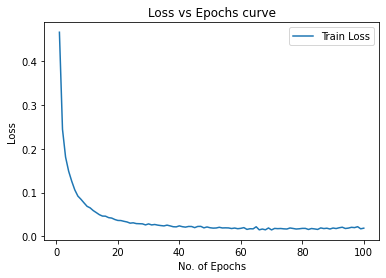

In [68]:
plot_loss_epochs(num_epochs, model1_train_loss)

In [11]:
def plot_img_preds(test_input_img, test_labels, test_preds):

    figure = plt.figure(figsize=(8, 8))
    cols, rows = 2,2
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(test_input_img), size=(1,)).item()
        ax = figure.add_subplot(rows, cols, i)
        plt.axis("off")
        ax.title.set_text('Label: {}, Pred Label: {}'.format(test_labels[sample_idx], test_preds[sample_idx]))
        plt.imshow(test_input_img[sample_idx].reshape(28,56).squeeze())
    plt.show()

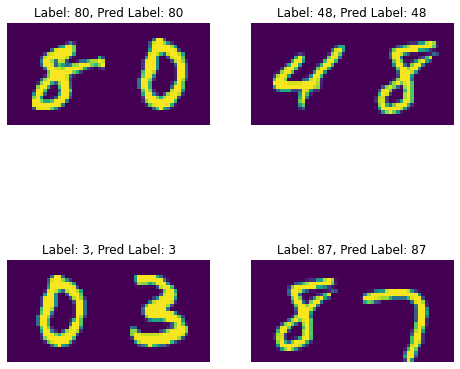

In [70]:
plot_img_preds(model1_test_input_img, model1_test_labels, model1_test_preds)

This concludes the assignment. We have trained another neural network with dropout layers to check how it performs on the same task.

#### Defining Neural Network with Dropout

In [12]:
model2 = nn.Sequential(
    nn.Linear(1568, 500), 
    nn.Dropout(0.2),
    nn.LeakyReLU(), 
    nn.Linear(500,500),
    nn.Dropout(0.2),
    nn.LeakyReLU(), 
    nn.Linear(500,200), 
    nn.Dropout(0.2),
    nn.LeakyReLU(), 
    nn.Linear(200, 100), 
    nn.LogSoftmax(dim=1)
)

In [13]:
model2

Sequential(
  (0): Linear(in_features=1568, out_features=500, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=500, out_features=500, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=500, out_features=200, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=200, out_features=100, bias=True)
  (10): LogSoftmax(dim=1)
)

In [14]:
num_epochs = 25
start = time.time()
model2_train_loss, model2_train_acc, model2_test_loss, model2_test_acc, model2_test_input_img, model2_test_labels, model2_test_preds = train_and_test_dnn(train_loader, test_loader, model2, num_epochs)
end = time.time()
print("Time taken: ", end-start)

| Epoch:[1]	Train_Loss: 0.6434	Accuracy: 0.8239
| Epoch:[2]	Train_Loss: 0.3121	Accuracy: 0.9144
| Epoch:[3]	Train_Loss: 0.2458	Accuracy: 0.9333
| Epoch:[4]	Train_Loss: 0.2115	Accuracy: 0.9422
| Epoch:[5]	Train_Loss: 0.1859	Accuracy: 0.9493
| Epoch:[6]	Train_Loss: 0.1723	Accuracy: 0.9530
| Epoch:[7]	Train_Loss: 0.1560	Accuracy: 0.9578
| Epoch:[8]	Train_Loss: 0.1483	Accuracy: 0.9602
| Epoch:[9]	Train_Loss: 0.1363	Accuracy: 0.9635
| Epoch:[10]	Train_Loss: 0.1268	Accuracy: 0.9658
| Epoch:[11]	Train_Loss: 0.1224	Accuracy: 0.9671
| Epoch:[12]	Train_Loss: 0.1145	Accuracy: 0.9693
| Epoch:[13]	Train_Loss: 0.1081	Accuracy: 0.9710
| Epoch:[14]	Train_Loss: 0.1020	Accuracy: 0.9729
| Epoch:[15]	Train_Loss: 0.0961	Accuracy: 0.9743
| Epoch:[16]	Train_Loss: 0.0910	Accuracy: 0.9755
| Epoch:[17]	Train_Loss: 0.0899	Accuracy: 0.9761
| Epoch:[18]	Train_Loss: 0.0859	Accuracy: 0.9769
| Epoch:[19]	Train_Loss: 0.0814	Accuracy: 0.9785
| Epoch:[20]	Train_Loss: 0.0798	Accuracy: 0.9789
| Epoch:[21]	Train_Loss: 0.07

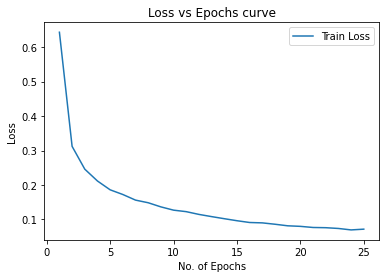

In [15]:
plot_loss_epochs(num_epochs, model2_train_loss)

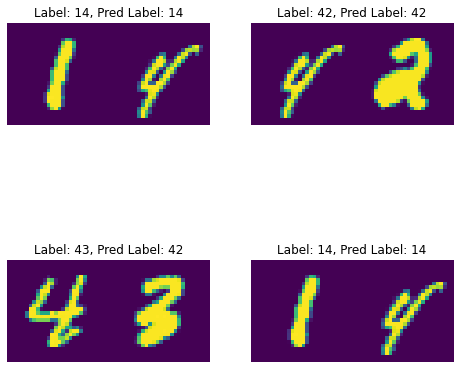

In [16]:
plot_img_preds(model2_test_input_img, model2_test_labels, model2_test_preds)

This model performed slightly worse than the previous at 25 epochs.

***
***